In [147]:
from scipy.integrate import odeint
from array import *
from scipy.optimize import curve_fit
import scipy.integrate as spi
from lmfit import minimize, Parameters, Model, fit_report
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import math
import pandas as pd
import seaborn as sns

%matplotlib inline


In [148]:
def PD_Model (Conc, E_base, E_max, IC50, Hill_Coeff):
    E = E_base + np.divide(np.multiply(E_max,np.power(Conc,Hill_Coeff)),(np.power(IC50, Hill_Coeff)+np.power(Conc,Hill_Coeff)))
    return E
PDModel = Model(PD_Model)

In [149]:
Data = [{'Tor':0, 'Ser':0, 'Res':0.0}]
Data.append({'Tor':0, 'Ser':0.63, 'Res':6.20})
Data.append({'Tor':0, 'Ser':1.25, 'Res':13.30})
Data.append({'Tor':0, 'Ser':2.5, 'Res':39.70})
Data.append({'Tor':0, 'Ser':5, 'Res':88.60})
Data.append({'Tor':0, 'Ser':10, 'Res':99.70})

Data.append({'Tor':0.31, 'Ser':0.0, 'Res':7.30})
Data.append({'Tor':0.31, 'Ser':0.63, 'Res':24.40})
Data.append({'Tor':0.31, 'Ser':1.25, 'Res':42.10})
Data.append({'Tor':0.31, 'Ser':2.5, 'Res':70.90})
Data.append({'Tor':0.31, 'Ser':5, 'Res':93.20})
Data.append({'Tor':0.31, 'Ser':10, 'Res':99.60})

Data.append({'Tor':0.63, 'Ser':0.0, 'Res':24.10})
Data.append({'Tor':0.63, 'Ser':0.63, 'Res':49.00})
Data.append({'Tor':0.63, 'Ser':1.25, 'Res':72.10})
Data.append({'Tor':0.63, 'Ser':2.5, 'Res':92.50})
Data.append({'Tor':0.63, 'Ser':5, 'Res':99.10})
Data.append({'Tor':0.63, 'Ser':10, 'Res':99.70})

Data.append({'Tor':1.25, 'Ser':0.0, 'Res':48.20})
Data.append({'Tor':1.25, 'Ser':0.63, 'Res':74.20})
Data.append({'Tor':1.25, 'Ser':1.25, 'Res':90.10})
Data.append({'Tor':1.25, 'Ser':2.5, 'Res':97.60})
Data.append({'Tor':1.25, 'Ser':5, 'Res':99.60})
Data.append({'Tor':1.25, 'Ser':10, 'Res':99.70})

Data.append({'Tor':2.5, 'Ser':0.0, 'Res':76.50})
Data.append({'Tor':2.5, 'Ser':0.63, 'Res':91.70})
Data.append({'Tor':2.5, 'Ser':1.25, 'Res':97.20})
Data.append({'Tor':2.5, 'Ser':2.5, 'Res':99.30})
Data.append({'Tor':2.5, 'Ser':5, 'Res':99.70})
Data.append({'Tor':2.5, 'Ser':10, 'Res':99.70})

Data.append({'Tor':5, 'Ser':0.0, 'Res':95.40})
Data.append({'Tor':5, 'Ser':0.63, 'Res':98.80})
Data.append({'Tor':5, 'Ser':1.25, 'Res':99.50})
Data.append({'Tor':5, 'Ser':2.5, 'Res':99.70})
Data.append({'Tor':5, 'Ser':5, 'Res':99.80})
Data.append({'Tor':5, 'Ser':10, 'Res':99.70})

In [150]:
Data_df = pd.DataFrame(Data)

Text(0.5, 15.0, 'Sertraline(uM)')

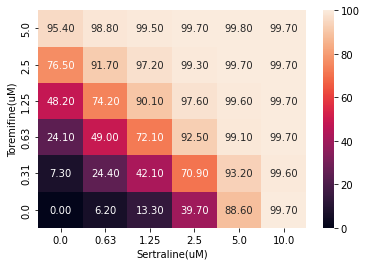

In [151]:
Data_plot = Data_df.pivot('Tor', 'Ser', 'Res')
ax1 = sns.heatmap(Data_plot, vmin =0, vmax = 100, annot = True, fmt = '0.2f')
ax1.invert_yaxis()
plt.ylabel('Toremifine(uM)')
plt.xlabel('Sertraline(uM)')

## Model A:
#### Toremifene downstream
#### Sertraline upstream

In [152]:
Tor = Data_df.Tor.unique()
Ser = Data_df.Ser.unique()
UpstreamRes = np.asarray(Data_df[Data_df.Tor==0].Res/100)
Downstream_Isol = np.asarray(Data_df[Data_df.Ser==0].Res/100)
Downstream_Res=[]
for upConc in Ser[1:]:
    Downstream_Res.append((np.asarray(Data_df[Data_df.Ser == upConc].Res)-np.asarray(Data_df[(Data_df.Tor == 0)&(Data_df.Ser == upConc)].Res))/100)

In [153]:
 Downstream_Res

[array([0.   , 0.182, 0.428, 0.68 , 0.855, 0.926]),
 array([0.   , 0.288, 0.588, 0.768, 0.839, 0.862]),
 array([0.   , 0.312, 0.528, 0.579, 0.596, 0.6  ]),
 array([0.   , 0.046, 0.105, 0.11 , 0.111, 0.112]),
 array([ 0.   , -0.001,  0.   ,  0.   ,  0.   ,  0.   ])]

In [154]:
PDModel.set_param_hint('E_base', value=0, vary = False)
PDModel.set_param_hint('E_max', value=0.5, min=0, max=1)
PDModel.set_param_hint('IC50', value=10, min=0, max=np.inf)
PDModel.set_param_hint('Hill_Coeff', value=3, min=0, max=np.inf)
params = PDModel.make_params()

In [155]:
result_Ser = PDModel.fit(UpstreamRes, params, Conc=Ser)
result_Tor_Isol = PDModel.fit(Downstream_Isol, params, Conc=Tor)

In [156]:
result_Ser

In [157]:
np.sum((result_Ser.best_fit-UpstreamRes)**2)

0.00685162936090483

In [177]:
for i in range(0,6):
    if i==0:
        E_S = result_Ser.best_fit
        E_T_Isol = result_Tor_Isol.best_fit
    else:
        E_S = np.vstack((E_S,result_Ser.best_fit))
        E_T_Isol = np.vstack((E_T_Isol,result_Tor_Isol.best_fit))

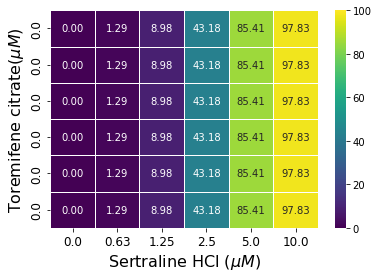

In [179]:
ax1 = sns.heatmap(E_S*100, vmin =0, vmax = 100, annot = True, fmt = '0.2f',cmap ='viridis', linewidth = 1, 
                  yticklabels = np.zeros(6), xticklabels =Ser )
ax1.invert_yaxis()
ax1.set_ylabel("Toremifene citrate($\mu M$)", fontsize=16)
ax1.tick_params(axis="y", labelsize = 12)
ax1.set_xlabel('Sertraline HCl ($\mu M$)', fontsize=16)
ax1.tick_params(axis="x", labelsize = 12)

In [158]:
result_Tor_Isol

In [159]:
for upConc in Ser[1:]:
    Downstream_Res.append((np.asarray(Data_df[Data_df.Ser == upConc].Res)-np.asarray(Data_df[(Data_df.Tor == 0)&(Data_df.Ser == upConc)].Res))/100)

In [160]:
np.sum((result_Tor_Isol.best_fit-Downstream_Isol)**2)

0.0015912329619520858

0.63
0.00034207454663275603
1.25
0.002103392513112719
2.5
0.0020211164507417533
5.0
0.0010919330832924567
10.0
1.0000000000001704e-06


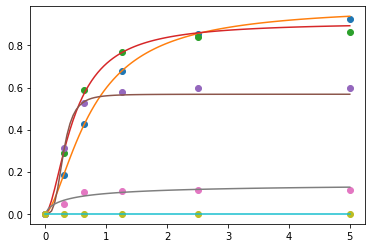

In [180]:
result_Tor=[]
IC50 =[0.6491,0.4138,0.3149,0.2981, 0.2960]
Hill = [1.673,1.924,2.622,3.53, 3.76]
i=0
Ecombo = result_Tor_Isol.best_fit
E_T = result_Tor_Isol.best_fit
for UpConc in Ser[1:]:
    print(UpConc)
    PDModel.set_param_hint('E_base', value=0, vary = False)
    PDModel.set_param_hint('IC50', value=IC50[i], min=0, max=np.inf)
    PDModel.set_param_hint('Hill_Coeff', value=Hill[i], min=0, max=np.inf)
    PDModel.set_param_hint('E_max', value=1-PDModel.eval(result_Ser.params, Conc = UpConc), min=0, max=1, vary=False)
    params = PDModel.make_params()
    Downstream_Res = (np.asarray(Data_df[Data_df.Ser == UpConc].Res)-
                      np.asarray(Data_df[(Data_df.Tor == 0)&(Data_df.Ser == UpConc)].Res))/100
   # Downstream_Res= (np.asarray(Data_df[Data_df.Ser == UpConc].Res)/100-
   #                   PDModel.eval(result_Ser.params, Conc = UpConc))
    result_Tor.append(PDModel.fit(Downstream_Res, params, Conc=Tor))
    print(np.sum((result_Tor[-1].best_fit-Downstream_Res)**2))
    Ecombo = np.vstack((Ecombo, PDModel.eval(result_Tor[i].params, Conc = Tor)+PDModel.eval(result_Ser.params, Conc = UpConc)))
    E_T = np.vstack((E_T,result_Tor[-1].best_fit))
    plt.plot(Tor, Downstream_Res, 'o')
    plt.plot(np.linspace(Tor[0],Tor[-1], 100), PDModel.eval(result_Tor[i].params, Conc = np.linspace(Tor[0],Tor[-1], 100)))
    i=i+1

In [162]:
result_Tor[4]

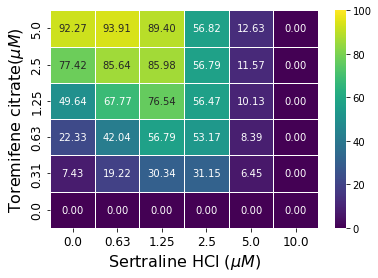

In [181]:
ax1 = sns.heatmap(E_T.T*100, vmin =0, vmax = 100, annot = True, fmt = '0.2f',cmap ='viridis', linewidth = 1, 
                  yticklabels = Tor, xticklabels =Ser)
ax1.invert_yaxis()
ax1.set_ylabel("Toremifene citrate($\mu M$)", fontsize=16)
ax1.tick_params(axis="y", labelsize = 12)
ax1.set_xlabel('Sertraline HCl ($\mu M$)', fontsize=16)
ax1.tick_params(axis="x", labelsize = 12)

In [166]:
Ecombo*100

array([[ 0.        ,  7.43165413, 22.32714312, 49.64207465, 77.42383613,
        92.26648395],
       [ 1.29497213, 20.515031  , 43.33034967, 69.06589951, 86.93107967,
        95.20820415],
       [ 8.98208345, 39.3189853 , 65.77163655, 85.52364674, 94.96538316,
        98.37943139],
       [43.17937575, 74.3312645 , 96.35191347, 99.64913597, 99.96892534,
        99.99726197],
       [85.40532502, 91.85904674, 93.79646649, 95.53222968, 96.97279857,
        98.03882958],
       [97.82901415, 97.82901415, 97.82901415, 97.82901415, 97.82901415,
        97.82901415]])

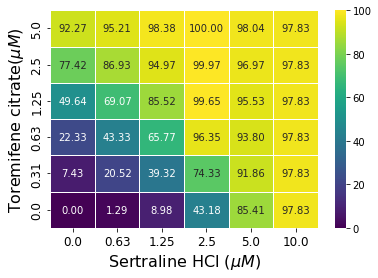

In [182]:
ax = sns.heatmap(Ecombo.T*100, vmin =0, vmax = 100, annot = True, fmt = '.2f',cmap ='viridis', linewidth = 1,
                 yticklabels = Tor, xticklabels = Ser)
ax.invert_yaxis()
ax.set_ylabel("Toremifene citrate($\mu M$)", fontsize=16)
ax.tick_params(axis="y", labelsize = 12)
ax.set_xlabel('Sertraline HCl ($\mu M$)', fontsize=16)
ax.tick_params(axis="x", labelsize = 12)

In [169]:
Data_array= np.asarray(Data_plot)
Ecombo[:5]*100

array([[ 0.        ,  7.43165413, 22.32714312, 49.64207465, 77.42383613,
        92.26648395],
       [ 1.29497213, 20.515031  , 43.33034967, 69.06589951, 86.93107967,
        95.20820415],
       [ 8.98208345, 39.3189853 , 65.77163655, 85.52364674, 94.96538316,
        98.37943139],
       [43.17937575, 74.3312645 , 96.35191347, 99.64913597, 99.96892534,
        99.99726197],
       [85.40532502, 91.85904674, 93.79646649, 95.53222968, 96.97279857,
        98.03882958]])

In [170]:
np.sum((Data_array.T-Ecombo*100)**2)

374.13961906428466

In [171]:
np.sum((Data_array-np.mean(Data_array))**2)

38829.66305555555

In [172]:
1-np.sum((Data_array-Ecombo.T*100)**2)/np.sum((Data_array-np.mean(Data_array))**2)

0.9903645926947915

In [183]:
delta_E = Ecombo.T*100-np.minimum(100,(E_T_Isol.T*100+E_S*100))

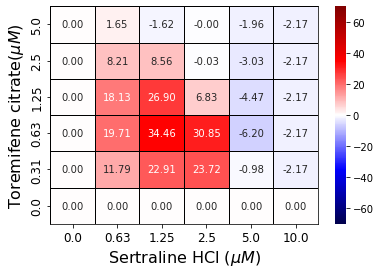

In [184]:
ax = sns.heatmap(delta_E, vmin =-70, vmax = 70, annot = True, fmt = '.2f', cmap ='seismic', linewidth = 0.5, 
                 linecolor = 'k', yticklabels = Tor, xticklabels = Ser)
ax.invert_yaxis()
ax.set_ylabel("Toremifene citrate($\mu M$)", fontsize=16)
ax.tick_params(axis="y", labelsize = 12)
ax.set_xlabel('Sertraline HCl ($\mu M$)', fontsize=16)
ax.tick_params(axis="x", labelsize = 12)
for _, spine in ax.spines.items(): 
    spine.set_visible(True) 
    spine.set_linewidth(0.75)

In [173]:
IC50_Tor = [1.26]
IC50_Tor_err = [0.097]
Hill_Tor = [1.799]
Hill_Tor_err = [0.174]
for i in range(0,len(Ser[1:])):
    IC50_Tor.append(result_Tor[i].params['IC50'].value)
    IC50_Tor_err.append(result_Tor[i].params['IC50'].stderr)
    Hill_Tor.append(result_Tor[i].params['Hill_Coeff'].value)
    Hill_Tor_err.append(result_Tor[i].params['Hill_Coeff'].stderr)

In [174]:
IC50_Tor_err

[0.097,
 0.011865275310370143,
 0.020408409015011154,
 0.014986636365450466,
 0.17686986116569994,
 1.786854885514785e+55]

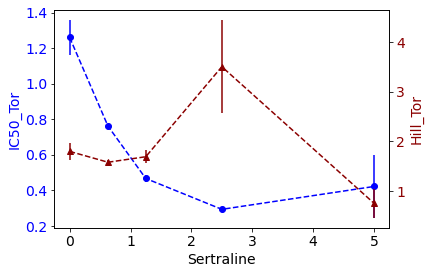

In [175]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx() 
ax1.errorbar(Ser[0:5], IC50_Tor[0:5], yerr = IC50_Tor_err[0:5], color = 'b', fmt = '--o')
ax1.set_ylabel("IC50_Tor", color='b', fontsize=14)
ax1.tick_params(axis="y", labelcolor='b',labelsize = 14)
ax1.set_xlabel('Sertraline', fontsize=14)
ax1.tick_params(axis="x", labelsize = 14)
ax2.errorbar(Ser[0:5], Hill_Tor[0:5], yerr = Hill_Tor_err[0:5], fmt = '--^', color = 'darkred')
ax2.set_ylabel("Hill_Tor", color='darkred', fontsize=14)
ax2.tick_params(axis="y", labelcolor='darkred', labelsize = 14)

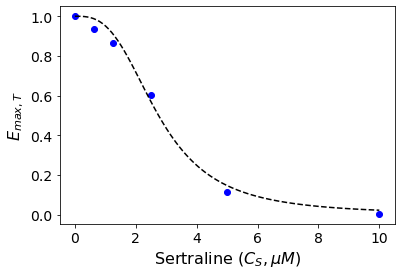

In [186]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(Ser, 1-np.asarray(Data_df[(Data_df.Tor == 0)].Res)/100, 'o', color = 'b')
ax1.plot(np.linspace(Ser[0], Ser[-1], 100), 
         1-PDModel.eval(result_Ser.params, Conc = np.linspace(Ser[0], Ser[-1], 100)), '--', color = 'k')
ax1.set_ylabel("$E_{max,T}$", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('Sertraline ($C_S, \mu M$)', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)

In [187]:
from sklearn.metrics import r2_score
r2_score(1-np.asarray(Data_df[(Data_df.Tor == 0)].Res)/100, 1-PDModel.eval(result_Ser.params, Conc = Ser))

0.9926893300154289

In [203]:
def exp(x, a, b, c):
    return a*np.exp(-b*(x))+c
exp_model = Model(exp)

exp_model.set_param_hint('a', value=1.5, min = 0, max = np.inf)
exp_model.set_param_hint('b', value=2, min=0, max=np.inf)
exp_model.set_param_hint('c', value=2.5, min=0, max=np.inf)


params = exp_model.make_params()

IC50_T = exp_model.fit(IC50_Tor[0:5], params, x = Ser[0:5], weights = 1.0/np.asarray(IC50_Tor_err[0:5]))
IC50_T_NW = exp_model.fit(IC50_Tor[0:5], params, x = Ser[0:5])


In [191]:
IC50_T

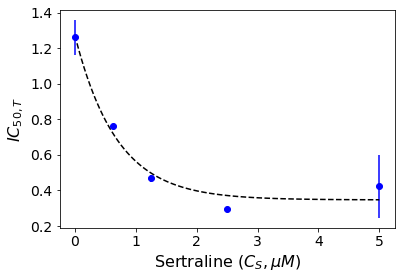

In [204]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.errorbar(Ser[0:5], IC50_Tor[0:5], yerr = IC50_Tor_err[0:5], fmt =  'o', color = 'b')
ax1.plot(np.linspace(Ser[0], Ser[4], 100), 
         exp_model.eval(IC50_T_NW.params, x=np.linspace(Ser[0], Ser[4], 100)), '--', color = 'k')
ax1.set_ylabel("$IC_{50,T}$", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('Sertraline ($C_S, \mu M$)', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)

In [197]:
from sklearn.metrics import r2_score
r2_score(IC50_Tor[0:5], exp_model.eval(IC50_T.params, x=Ser[0:5]), sample_weight= 1.0/np.asarray(IC50_Tor_err[0:5]))

0.9804867816678322

In [205]:
r2_score(IC50_Tor[0:5], exp_model.eval(IC50_T_NW.params, x=Ser[0:5]))

0.9755353834666026

In [201]:
def binomial(x, a, b, c, d):
    return a*x+b*x**2+c*x**3+d
binomial_model = Model(binomial)

binomial_model.set_param_hint('a', value=-2, min = -np.inf, max = 0)
binomial_model.set_param_hint('b', value=0.2, min=0, max=np.inf)
binomial_model.set_param_hint('c', value=-1, min=-np.inf, max=0)
binomial_model.set_param_hint('d', value=6, min=0, max=np.inf)
params = binomial_model.make_params()

Hill_T = binomial_model.fit(Hill_Tor[0:5], params, x =Ser[0:5], weights = 1.0/np.asarray(Hill_Tor_err[0:5]) )

Hill_T_NW = binomial_model.fit(Hill_Tor[0:5], params, x =Ser[0:5] )

In [199]:
Hill_T

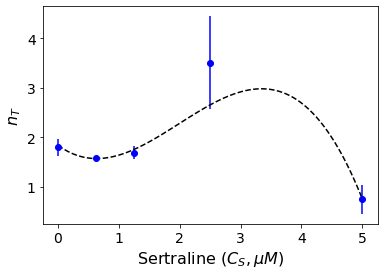

In [211]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.errorbar(Ser[0:5], Hill_Tor[0:5], yerr = Hill_Tor_err[0:5], fmt =  'o', color = 'b')
ax1.plot(np.linspace(Ser[0], Ser[4], 100), 
         binomial_model.eval(Hill_T.params, x=np.linspace(Ser[0], Ser[4], 100)), '--', color = 'k')
ax1.set_ylabel("$n_{T}$", fontsize=16)
ax1.tick_params(axis="y", labelsize = 14)
ax1.set_xlabel('Sertraline ($C_S, \mu M$)', fontsize=16)
ax1.tick_params(axis="x", labelsize = 14)

In [210]:
r2_score(Hill_Tor[0:5], binomial_model.eval(Hill_T_NW.params, x=Ser[0:5]),sample_weight = 1.0/np.asarray(Hill_Tor_err[0:5]))

0.9067359122506877

In [208]:
r2_score(Hill_Tor[0:5], binomial_model.eval(Hill_T.params, x=Ser[0:5]),sample_weight = 1.0/np.asarray(Hill_Tor_err[0:5]))

0.8762815322191077